In [1]:
# Import packages and read data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

df_2_raw = pd.read_excel('Adops & Data Scientist Sample Data.xlsx', sheet_name=1, header=None, names=['A','B','C'])

### Remove outliers

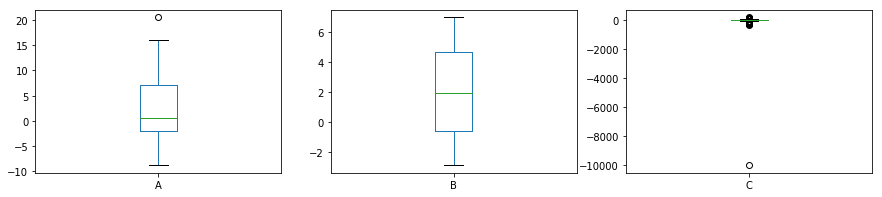

In [2]:
#Check the distribution of data, C turns out to have an outliner that could significantly influence regression models

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
for i in range(3):
    df_2_raw.iloc[:,i].plot.box(ax=axes[i])

In [3]:
# Remove the outlier
df_2_raw = df_2_raw.drop(df_2_raw.C.idxmin(), axis=0)

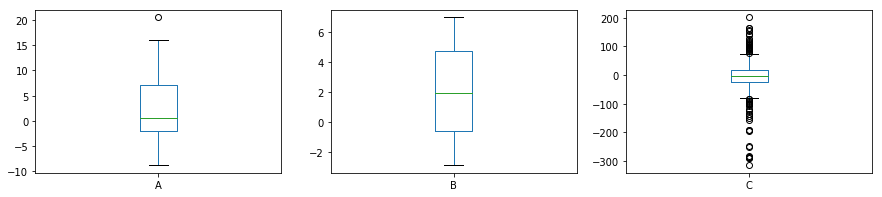

In [4]:
# Check distributions again

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
for i in range(3):
    df_2_raw.iloc[:,i].plot.box(ax=axes[i])

### Split data into train set and test set

In [5]:
test_index = df_2_raw.sample(frac=0.2).index
test = df_2_raw.iloc[test_index]
df_2 = df_2_raw.drop(test_index)

### Feature engineering

##### Group data by having ‘A’ value in a certain range, so we can assume that ‘A’ doesn't change a lot in each group.
##### Then plot B versus C, and color the dots in different ways for each group.
##### As the plot illustrates, there's a linear relationship between B and C when A is fixed. 
##### And the coefficients change when A changes

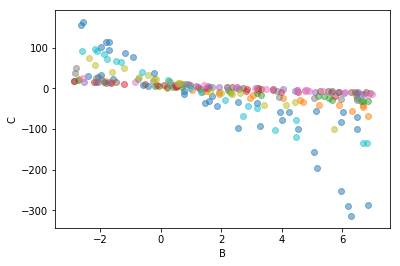

In [6]:
df_2.sort_values(by=['A'], inplace=True)

for i in range(11):
    plt.scatter(df_2.B[i*20:(i+1)*20], df_2.C[i*20:(i+1)*20], alpha=.5)
#fig.suptitle('title')
plt.xlabel('B')
plt.ylabel('C')
plt.show()

##### Group data by having ‘B’ value in a certain range, so we can assume that ‘B’ doesn't change a lot in each group.
##### Then plot A versus C, and color the dots in different ways for each group.
##### As the plot illustrates, there's a quadratic relationship between A and C when B is fixed. 
##### And the coefficients change when B changes

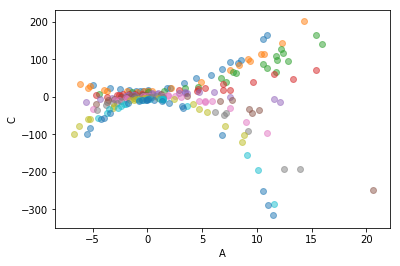

In [7]:
df_2.sort_values(by=['B'], inplace=True)

for i in range(11):
    plt.scatter(df_2.A[i*20:(i+1)*20], df_2.C[i*20:(i+1)*20], alpha=.5)
plt.xlabel('A')
plt.ylabel('C')
plt.show()

##### Construct a variable: $A^2 \times B$, which can fully represent the relationship I explored above

In [8]:
df_2['A^2*B'] = df_2.A**2*df_2.B
test['A^2*B'] = test.A**2*test.B

### Train model

##### I start with gradient descent method to find the optimal coefficients, which doesn't require additional packages

In [9]:
X = df_2.drop(['C'], axis=1)
X = np.concatenate((np.ones([len(df_2),1]), X), axis=1)
y = df_2.C.values

In [10]:
class LinearRegression:
    def __init__(self, eta=0.01, N=1000):
        self.eta = eta
        self.N = N
        pass
        
    def mse(self, beta, X, y):
        y_pred = np.dot(X, beta)
        y_diff = y_pred - y
        return np.mean(y_diff**2)

    def gradient(self, beta, X, y):
        y_pred = np.dot(X, beta)
        y_diff = y_pred - y
        return 2*np.dot(X.T, y_diff)/len(X)
    
    def fit(self, X, y):
        beta = np.random.normal(size=X.shape[1])
        self.records = [self.mse(beta, X, y)]
        for i in range(self.N):
            beta = beta - self.eta*self.gradient(beta,X,y)
            self.records.append(self.mse(beta, X, y))
        self.beta = beta
        pass
    
    def predict(self, X):
        y = np.dot(X, self.beta)
        return y

In [11]:
#Set learning rate eta as 0.00001 and number of iterations=1000

model = LinearRegression(eta=0.00001, N=1000)
model.fit(X, y)

##### The parameters tuning is very tricky, since it could be either too large to converge or too small to learn fast
##### Also, since there's only one learning rate to control the learning of all coefficients, when some have already converged, others may not be able to converge as well

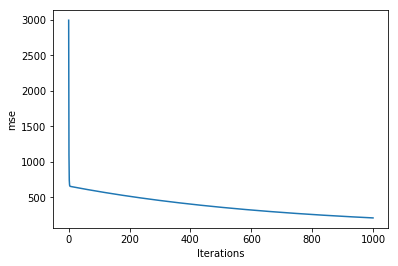

In [12]:
plt.plot(model.records)
plt.xlabel('Iterations')
plt.ylabel('mse')
plt.show()

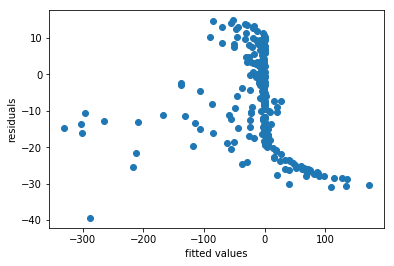

In [13]:
y_pred = model.predict(X)
residual = y_pred - y
plt.scatter(y_pred, residual)
plt.xlabel('fitted values')
plt.ylabel('residuals')
plt.show()

In [14]:
def r2_score(y, y_pred):
    mean_y = np.mean(y)
    sst = sum((y - mean_y) ** 2)
    sse = sum((y - y_pred) ** 2)
    r2 = 1 - (sse / sst)
    return r2
r2_score(y, y_pred)

0.9575458925413538

In [15]:
print('The coefficients of intercept, A, B, A^2*B are: ', model.beta)

The coefficients of intercept, A, B, A^2*B are:  [-0.09421713  0.70159706  0.03472671 -0.41077612]


##### From Residuals versus Fitted values we can know that there's still some information our model hasn't learned yet.
##### From R_Squared we can know that we actually have a pretty decent result.

### Analytical solution

##### If np.linalg.lstsq is allowed to use, then we can have an accurate analytical solution:

In [16]:
analytical_beta = np.linalg.lstsq(X, y, rcond=-1)[0]

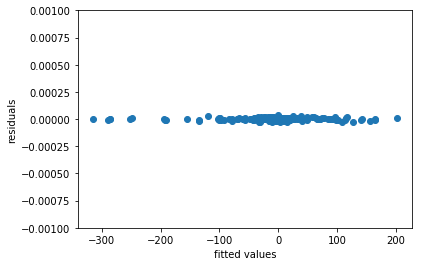

In [17]:
y_pred = np.dot(X, analytical_beta)
residual = y_pred - y
plt.scatter(y_pred, residual)
plt.ylim(-0.001, 0.001)
plt.xlabel('fitted values')
plt.ylabel('residuals')
plt.show()

In [18]:
r2_score(y, y_pred)

0.999999999999979

In [19]:
print('The analytical coefficients of intercept, A, B, A^2*B are: ', analytical_beta)

The analytical coefficients of intercept, A, B, A^2*B are:  [10.00000146  2.00000008 -3.00000009 -0.4       ]


##### We can see that the residuals are pretty random and R_squared is very close to 1, which performs better than before

### Model performance on test data

In [20]:
X_test = test.drop(['C'], axis=1)
X_test = np.concatenate((np.ones([len(test),1]), X_test), axis=1)
y_test = test.C.values

##### RMSE

In [22]:
y_test_pred = np.dot(X_test, analytical_beta)
test_residual = y_test_pred - y_test
np.mean(test_residual**2)**(1/2)

1.0173684057229347e-05